# TP 4 : Fillrates and Market Making

## I. Fillrate

### 1. Definition

* Instantaneous volume obtained when orders are posted inside the orderbook
* Dependent on order parameters (size, distance, duration, type)
* Also dependent on market factors (volatility, spread, volume, etc)
* Can be estimated by modeling from empirical data.

### 2. Fillrate at Distance

We consider an agent who catches liquidity (at the bid or at the ask) on a market by only posting passive limit orders. Her placement strategy consists in
* posting a limit order of size 1 at a distance $d$ (in ticks) from the best price (bid or ask) ;
* waiting $n$ trades or $t$ minutes ;
* if the order is executed before the end of the period, she instantenously posts the same order (size, price, volume) ;
* counting at the end the number of executions of her type of orders on the period ;
* canceling the last unexecuted order and replacing the same quantity at the same distance $d$ for the same duration ($n$ or $t$).

**a. Buy Order : $d=0$ (best bid), $n=15$ trades**

In [1]:
import numpy as np
import pandas as pd 

import matplotlib.pylab as plt
from matplotlib.dates import DateFormatter
from matplotlib.ticker import Formatter
from matplotlib import cbook, dates

from datetime import datetime, timedelta

import statsmodels.api as sm
from tqdm import tqdm
import os
from PIL import Image

In [2]:
%matplotlib inline

In [3]:
# for plots: 
class MyFormatter(Formatter):
    def __init__(self, dates, fmt='%H:%M'):
        self.dates = dates
        self.fmt = fmt

    def __call__(self, x, pos=0):
        """Return the label for time x at position pos."""
        ind = int(round(x))
        if ind >= len(self.dates) or ind < 0:
            return ''
        return self.dates[ind].strftime(self.fmt)

In [4]:
def get_fill_rate(df_trades, date_t, d, period, tick):
    time_index = df_trades.loc[date_t].droplevel(0).index
    best_bid_prices = df_trades.loc[date_t, "BidPrice"].to_numpy(copy=True)
    best_ask_prices = df_trades.loc[date_t, "AskPrice"].to_numpy(copy=True)
    traded_prices = df_trades.loc[date_t, "TradedPrice"].to_numpy(copy=True)
    M = best_bid_prices.shape[0]
    fillrate, time_index_fillrate, midPrices = [], [], []
    i = 0
    while i < M:
        cnt = 0
        last_price = best_bid_prices[i] - d*tick
        time_index_fillrate.append(time_index[i])
        midPrices.append((best_ask_prices[i] + best_ask_prices[i]) / 2)
        for _ in range(period):
            if i < M:
                if traded_prices[i] <= last_price:
                    cnt += 1
                    last_price = best_bid_prices[i] - d*tick
            i += 1
        fillrate.append(cnt)
    fillrate = np.array(fillrate)
    return fillrate, time_index_fillrate, midPrices

In [5]:
# compare with duration T in minutes
def get_fill_rate_delta_time(df_trades, date_t, d, period, tick):
    """
    period is a timedelta
    """
    df_trades = df_trades.loc[date_t].droplevel(0)
    best_bid_prices = df_trades.loc[date_t, "BidPrice"].to_numpy(copy=True)
    best_ask_prices = df_trades.loc[date_t, "AskPrice"].to_numpy(copy=True)
    traded_prices = df_trades.loc[date_t, "TradedPrice"].to_numpy(copy=True)
    M = best_bid_prices.shape[0]
    fillrate, time_index_fillrate, midPrices = [], [], []
    i = 0
    while i < M:
        cnt = 0
        last_price = best_bid_prices[i] - d*tick
        end_time = df_trades.index[i] + period
        time_index_fillrate.append(df_trades.index[i])
        midPrices.append((best_ask_prices[i] + best_ask_prices[i]) / 2)
        while i < M and df_trades.index[i] <= end_time:
            if traded_prices[i] <= last_price:
                cnt += 1
                last_price = best_bid_prices[i] - d*tick
            i += 1
        fillrate.append(cnt)
    fillrate = np.array(fillrate)
    return fillrate, time_index_fillrate, midPrices

In [6]:
def get_fill_rate_ask(df_trades, date_t, d, period, tick):
    time_index = df_trades.loc[date_t].droplevel(0).index
    best_bid_prices = df_trades.loc[date_t, "BidPrice"].to_numpy(copy=True)
    best_ask_prices = df_trades.loc[date_t, "AskPrice"].to_numpy(copy=True)
    traded_prices = df_trades.loc[date_t, "TradedPrice"].to_numpy(copy=True)
    M = best_bid_prices.shape[0]
    fillrate, time_index_fillrate, midPrices = [], [], []
    i = 0
    while i < M:
        cnt = 0
        last_price = best_ask_prices[i] + d*tick
        time_index_fillrate.append(time_index[i])
        midPrices.append((best_ask_prices[i] + best_ask_prices[i]) / 2)
        for _ in range(period):
            if i < M:
                if traded_prices[i] >= last_price:
                    cnt += 1
                    last_price = best_ask_prices[i] + d*tick
            i += 1
        fillrate.append(cnt)
    fillrate = np.array(fillrate)
    return fillrate, time_index_fillrate, midPrices

def get_fill_rate_ask_delta_time(df_trades, date_t, d, period, tick):
    """
    period is a timedelta
    """
    time_index = df_trades.loc[date_t].droplevel(0).index
    best_bid_prices = df_trades.loc[date_t, "BidPrice"].to_numpy(copy=True)
    best_ask_prices = df_trades.loc[date_t, "AskPrice"].to_numpy(copy=True)
    traded_prices = df_trades.loc[date_t, "TradedPrice"].to_numpy(copy=True)
    M = best_bid_prices.shape[0]
    fillrate, time_index_fillrate, midPrices = [], [], []
    i = 0
    while i < M:
        cnt = 0
        last_price = best_ask_prices[i] + d*tick
        time_index_fillrate.append(time_index[i])
        midPrices.append((best_ask_prices[i] + best_ask_prices[i]) / 2)
        end_time = time_index[i] + period
        while i < M and time_index[i] <= end_time:
            if traded_prices[i] >= last_price:
                cnt += 1
                last_price = best_ask_prices[i] + d*tick
            i += 1
        fillrate.append(cnt)
    fillrate = np.array(fillrate)
    return fillrate, time_index_fillrate, midPrices


In [7]:
def plot_fill_rate(df_trades, date_t, d, n, tick):
    fillrate, time_index_fillrate, midPrices = get_fill_rate(df_trades, date_t, d, n, tick)
    # top midprice bottom fillrate
    # plot mid price of LVMH on 2011-01-03 every 15 trades
    fig, ax = plt.subplots(2, 1, figsize=(12, 10))
    for i in range(2):
        ax[i].xaxis.set_major_formatter(MyFormatter(time_index_fillrate))
    ax[0].step(midPrices, 'b-')
    markerline, stemlines, baseline = ax[1].stem(fillrate, markerfmt='D', linefmt='grey', basefmt=" ")
    markerline.set_markerfacecolor('none')
    plt.setp(markerline, markersize = 3)
    fig.autofmt_xdate()
    plt.show()

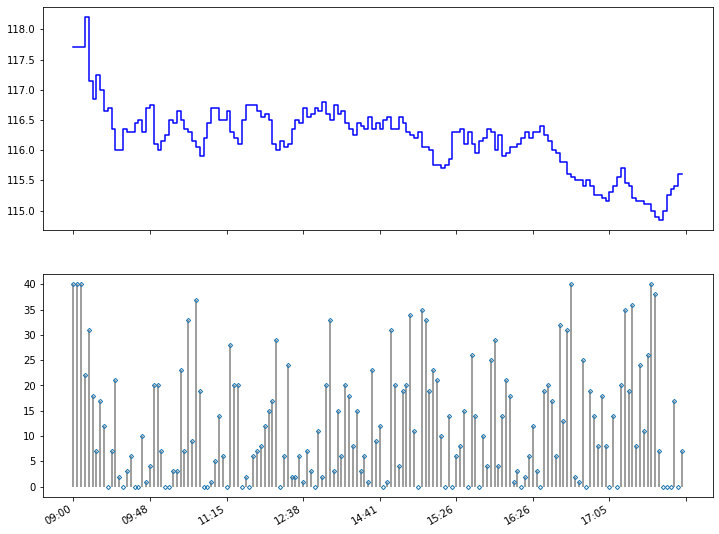

In [8]:
stock_name = "LVMH"
df_trades = pd.read_hdf(f"Data/{stock_name}.h5")
df_trades.loc[:, "Date"] = df_trades.index.date
df_trades = df_trades.reset_index().set_index(["Date", "Time"])
date_t = "2011-12-05"
d, n = 0, 40
tick = 0.05

plot_fill_rate(df_trades, date_t, d, n, tick)

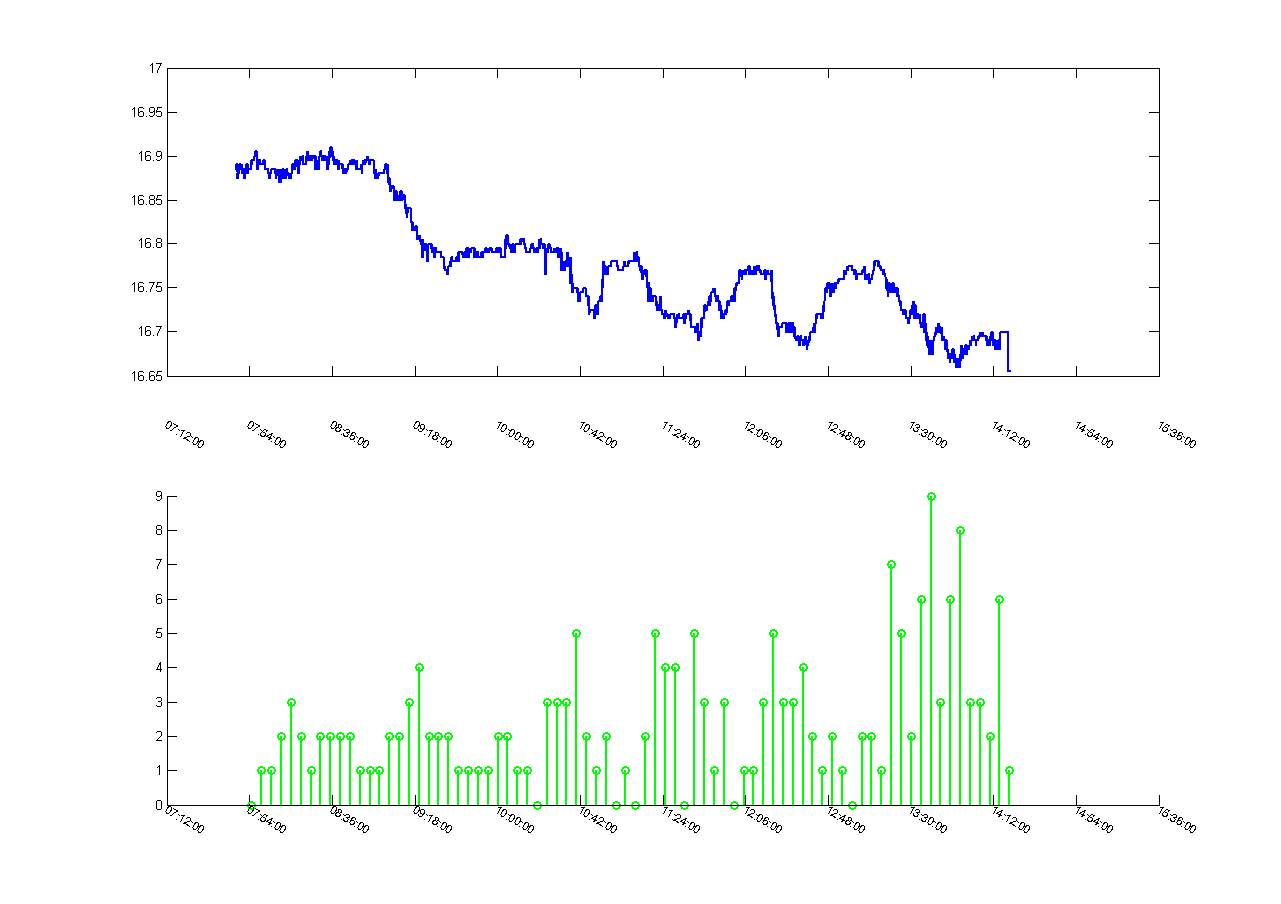

In [7]:
from IPython.display import Image
Image(filename='imgs/SingleFillrate.png')
# Top : mid price of FTE.PA on 22/11/2010; bottom : fillrate.

* Order Size = 1
* Fillrate = Executed volume on 15 trades slice
* Strong correlation to market movements – therefore to volatility

**b. Buy Order : $d=0$ (best bid) vs $d=1$ (second best bid), $n=15$ trades**

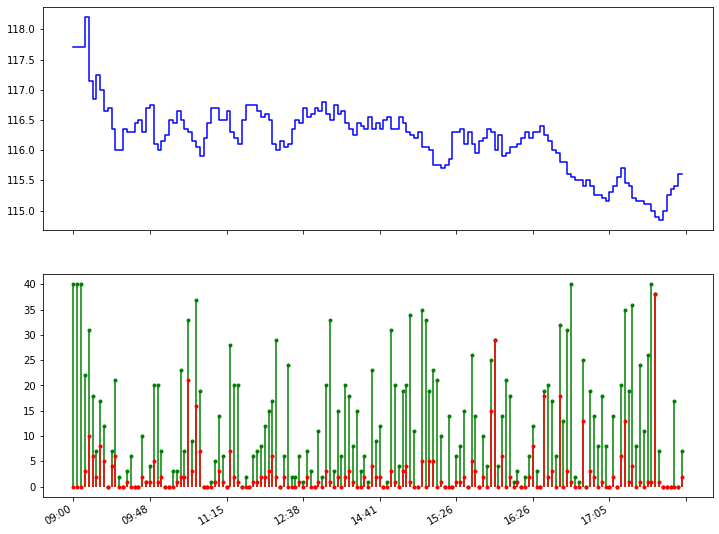

In [9]:
n = 40 # change frequency otherwise too much data points
fillrate_0, time_index_fillrate, midPrices = get_fill_rate(df_trades, date_t, 0, n, tick)
fillrate_1, time_index_fillrate, midPrices = get_fill_rate(df_trades, date_t, 1, n, tick)
assert(all(fillrate_0 >= fillrate_1))
# top midprice bottom fillrate
# plot mid price of LVMH on 2011-01-03 every 15 trades
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
for i in range(2):
    ax[i].xaxis.set_major_formatter(MyFormatter(time_index_fillrate))
ax[0].step(midPrices, 'b-')
markerline, stemlines, _ = ax[1].stem(fillrate_0, markerfmt='go', linefmt='g-', basefmt=" ")
plt.setp(markerline, 'markerfacecolor', 'g', markersize = 3)
markerline_1, stemlines_1, _ = ax[1].stem(fillrate_1, markerfmt='ro', linefmt='r-', basefmt=" ")
plt.setp(markerline_1, 'markerfacecolor', 'r', markersize = 3)
fig.autofmt_xdate()
plt.show()

We got similar results as the figure blow. at d = 1, there are much less trades occurred. The number of trades at d = 1 also correlates with the underlying asset's volatility

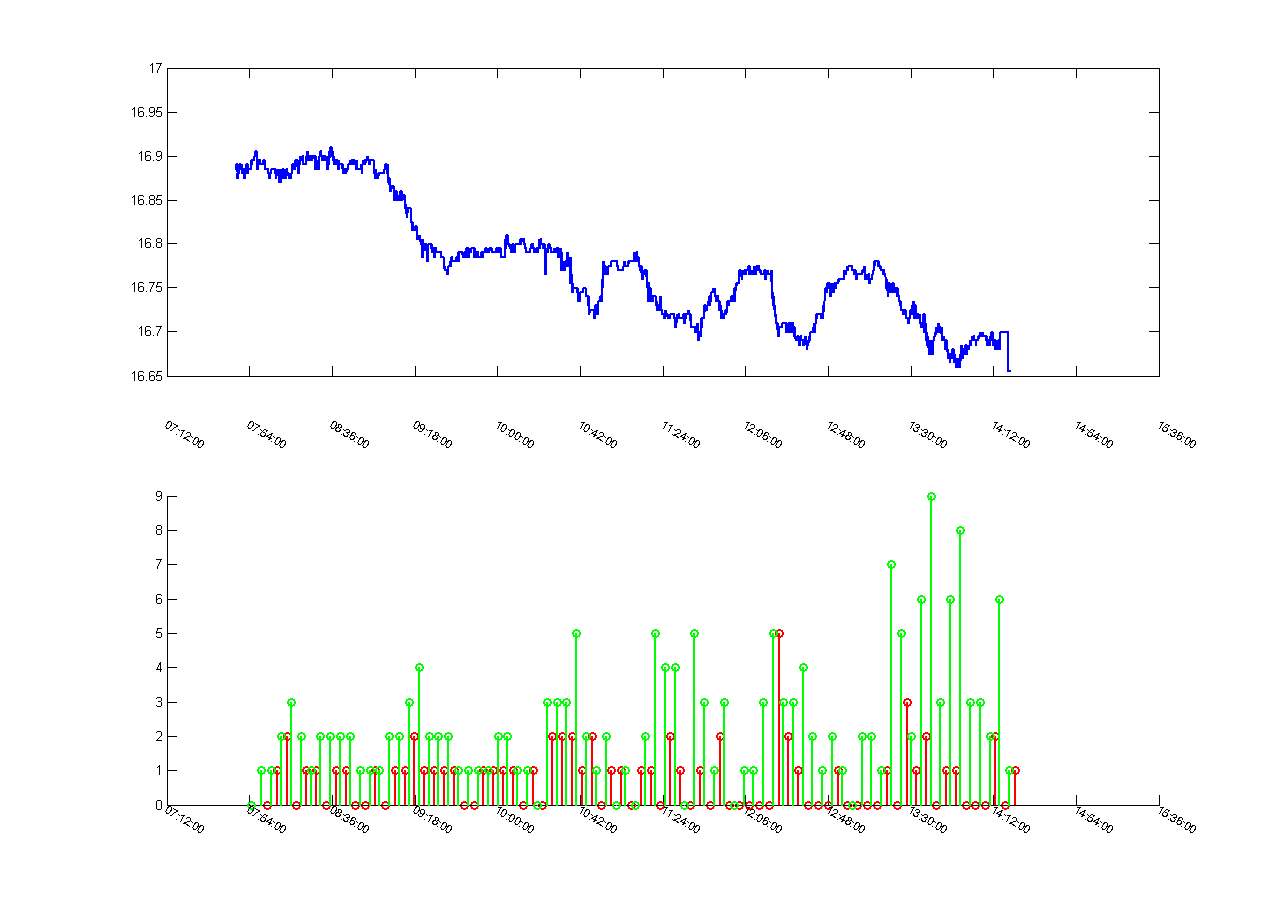

In [9]:
Image(filename='imgs/MultipleDFillrate2.png')

_Legend_ : $d=0$ in green, $d=1$ in red

**c. Buy Order : $n=15$ trades vs $n=30$ trades, $d=0$ (best bid)**

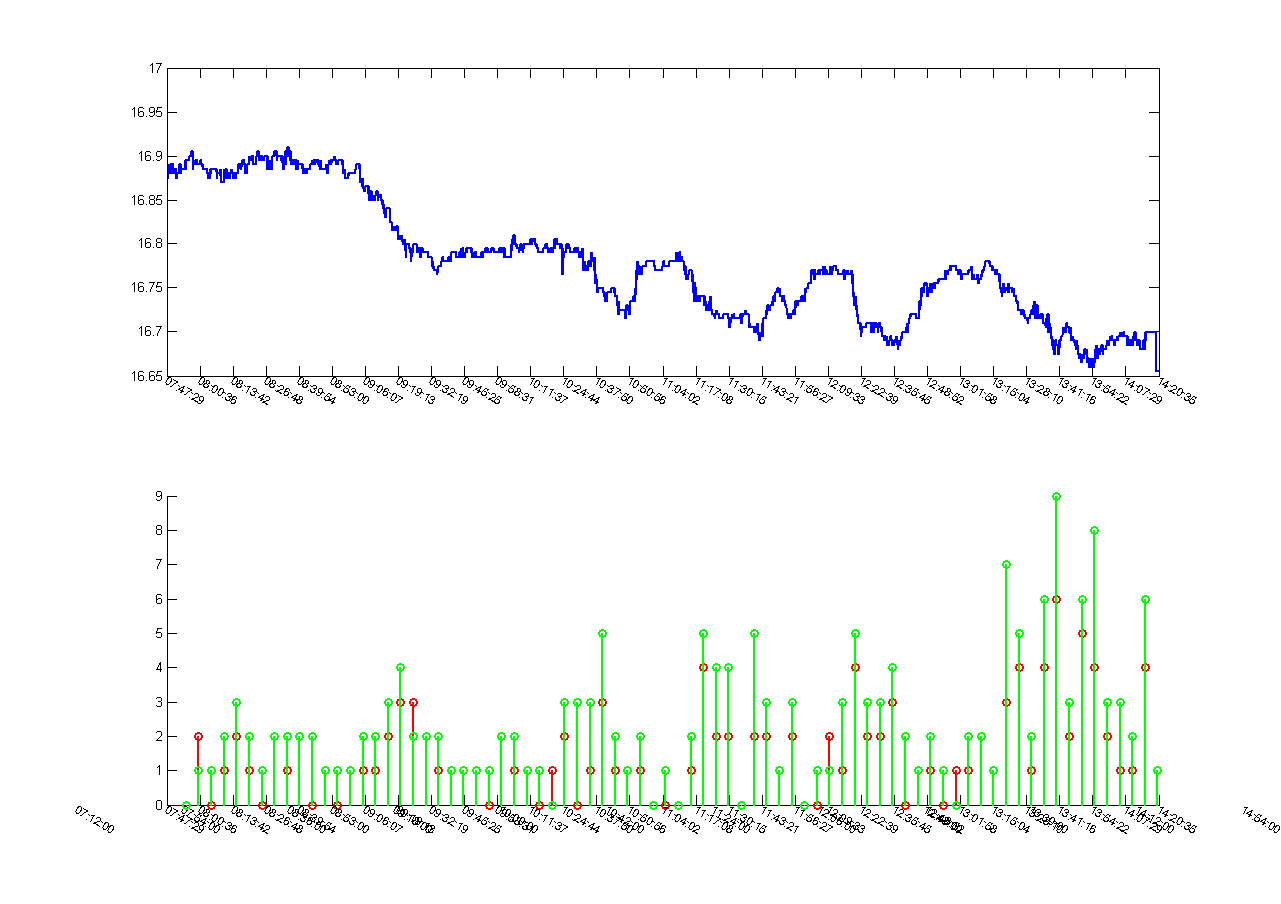

In [10]:
Image(filename='imgs/MultipleDtFillrate.png')

_Legend_ : $n=15$ in green, $n=30$ in red

**d. Both : $d=0$ & $n=15$ vs $d=1$ & $n=30$**

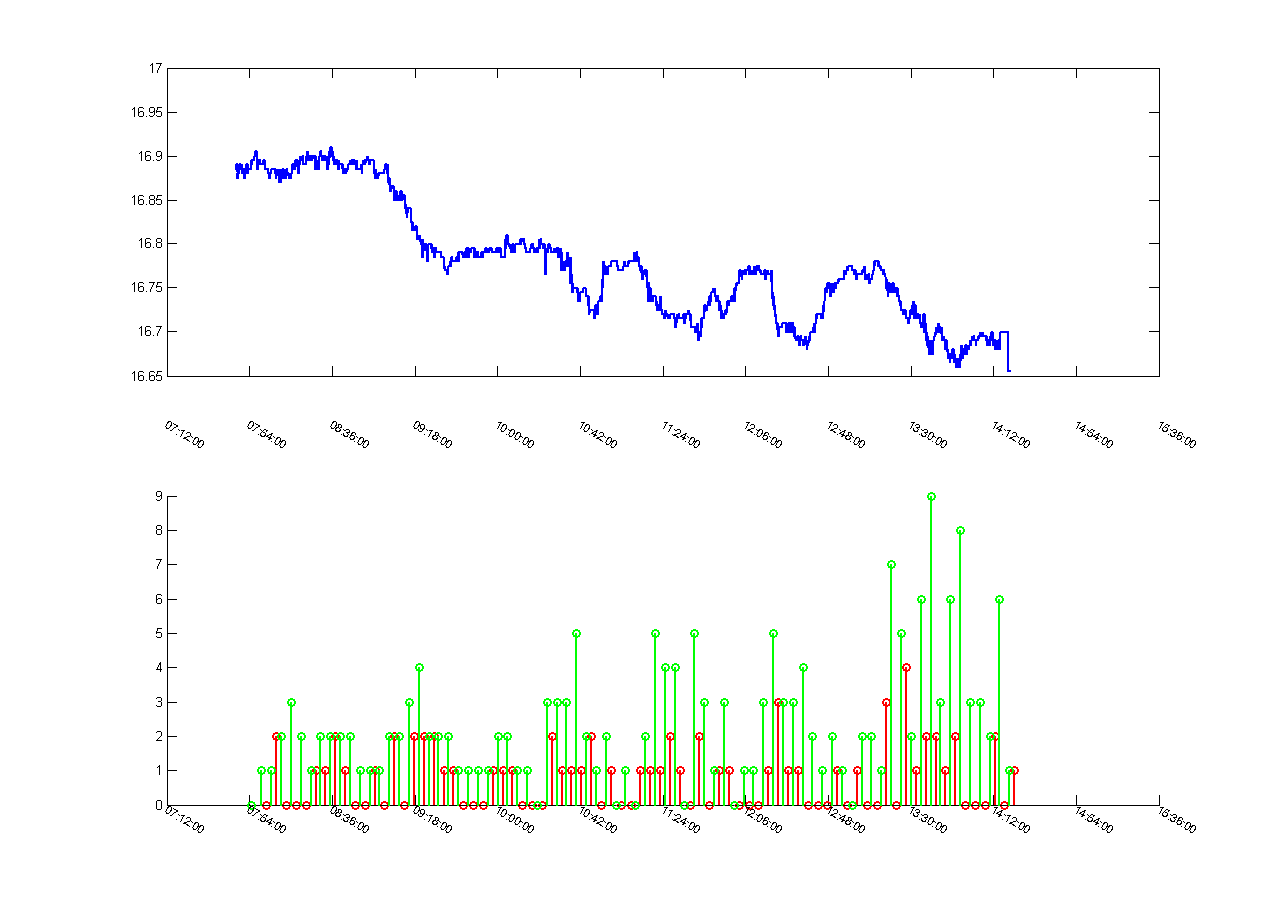

In [11]:
Image(filename='imgs/MultipleDFillrate.png')

_Legend_ : $d=0$ & $n=15$ in green, $d=1$ & $n=30$ in red

### 3. Implementation

a. Plot the price dynamics and the associated fillrate of this posting strategy.
```
Already done above. 
```

b. Compare with different durations $t$ (in minutes).
```
we compared duration of 2 minutes with 5 minutes.
```

c. Compare with different fixed distances ($0\leq d\leq 4$).

d. Comment.
```

```

top midprice bottom fillrate

plot mid price of LVMH on `date_t` every `period` minutes

In [10]:
# choose two different periodes in minutes
n1, n2 = 2, 5
period1 = timedelta(minutes=n1)
period2 = timedelta(minutes=n2)
# choose d = 0 at bestbid 
d = 0
fillrate_0, time_index_fillrate_0, midPrices_0 = get_fill_rate_delta_time(df_trades, date_t, 0, period1, tick)
fillrate_1, time_index_fillrate_1, midPrices_1 = get_fill_rate_delta_time(df_trades, date_t, 0, period2, tick)
x_fill_0 = np.linspace(0, 1, len(fillrate_0))
x_fill_1 = np.linspace(0, 1, len(fillrate_1))
# assert(all(fillrate_0 >= fillrate_1))

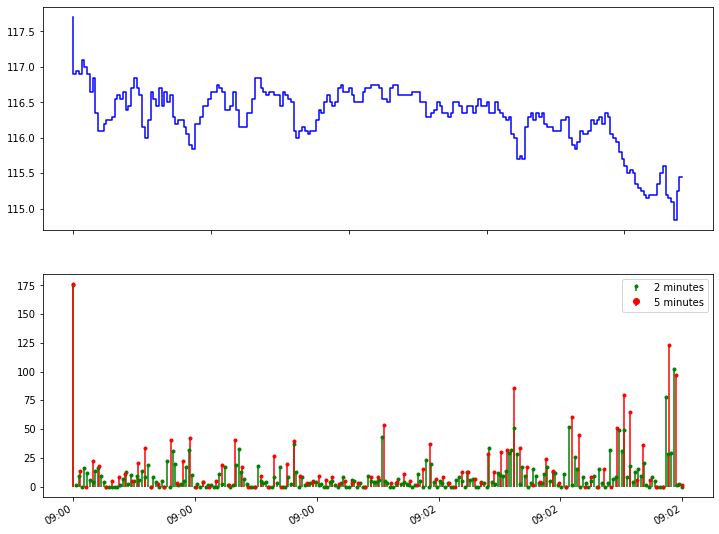

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
for i in range(2):
    ax[i].xaxis.set_major_formatter(MyFormatter(time_index_fillrate_0))
ax[0].step(midPrices_0, 'b-')
markerline, stemlines, _ = ax[1].stem(x_fill_0,
                                        fillrate_0, 
                                        markerfmt='go', 
                                        linefmt='g-', 
                                        basefmt=" ", 
                                        label=f"{n1} minutes")

plt.setp(markerline, 'markerfacecolor', 'g', markersize = 3)
markerline_1, stemlines_1, _ = ax[1].stem(x_fill_1,
                                        fillrate_1, 
                                        markerfmt='ro', 
                                        linefmt='r-', 
                                        basefmt=" ", 
                                        label=f"{n2} minutes")
ax[1].legend()
plt.setp(markerline_1, 'markerfacecolor', 'r', markersize = 3)
fig.autofmt_xdate()
plt.show()

For a longer duration, the number of trades is larger. Both have almost the same trends, and high volume at open and close of the market. 

### Compare different distances 0 <= d <= 4

top midprice bottom fillrate

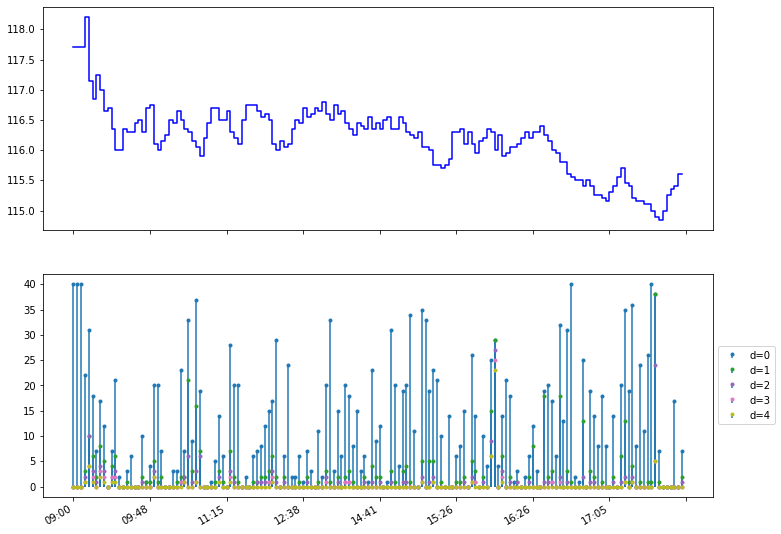

In [12]:
n = 40 # change frequency otherwise too much data points
fillrates = []
time_index_fillrate, midPrices = None, None
for d in range(5):
    fillrate_d, time_index_fillrate_0, midPrices_0 = get_fill_rate(df_trades, date_t, d, n, tick)
    if d == 0: 
        time_index_fillrate = time_index_fillrate_0
        midPrices = midPrices_0
    fillrates.append(fillrate_d)

fig, ax = plt.subplots(2, 1, figsize=(12, 10))
for i in range(2):
    ax[i].xaxis.set_major_formatter(MyFormatter(time_index_fillrate))
ax[0].step(midPrices, 'b-')
for i, fillrate in enumerate(fillrates):
    markerline, stemlines, _ = ax[1].stem(fillrate, markerfmt='o', linefmt='-', basefmt=" ", label=f"d={i}")
    plt.setp(markerline, markersize = 3)
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.autofmt_xdate()
plt.show()

When the distance d increases, the number of trades decrease very quickly. At d = 4, most number are zero, which means the trade is unlikly to be executed unless the market is very volatile. 

### Switch to ask price

In [15]:
period = timedelta(minutes=3)
fillrate, time_index_fillrate, midPrices = get_fill_rate_ask_delta_time(df_trades, date_t, 0, period, tick)

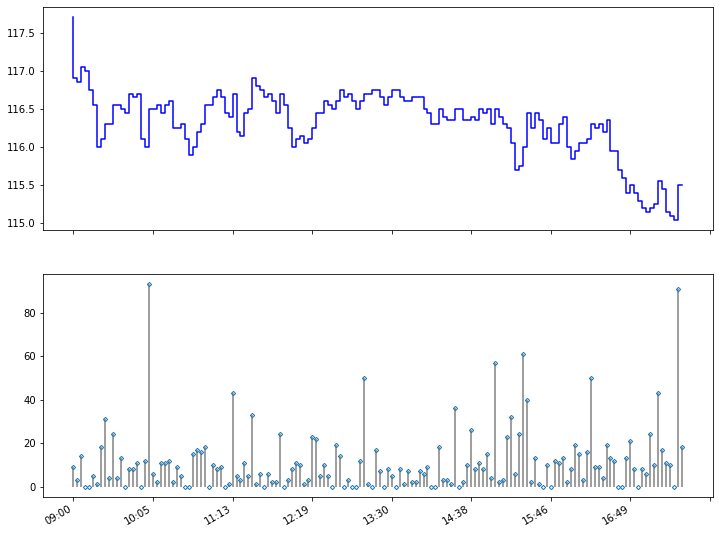

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
for i in range(2):
    ax[i].xaxis.set_major_formatter(MyFormatter(time_index_fillrate))
ax[0].step(midPrices, 'b-')
markerline, stemlines, baseline = ax[1].stem(fillrate, markerfmt='D', linefmt='grey', basefmt=" ")
markerline.set_markerfacecolor('none')
plt.setp(markerline, markersize = 3)
fig.autofmt_xdate()
plt.show()

## II. Inventory and Market Making

### 1. Inventory

* Volume obtained during the day using a liquidity seeking tactic
* Can be regarded as the integral of the fillrate over a period of time
* Thus it is dependent on the same parameters.



**Implementation**

a. Plot the inventory evolution of the previous strategy depending on $d$ and $t$.

b. Study the dependence of this inventory $V$ on volatility $\sigma$ and spread $S$.

c. Comment.

### a. Plot the inventory evolution of the previous strategy depending on $d$ and $t$.

In [17]:
t_range = [1,2,5,10]
FR_t = [0] * len(t_range)
TimeInd = [0] * len(t_range)
for i,t in enumerate(t_range):
    FR_t[i],TimeInd[i], midPrices = get_fill_rate_delta_time(df_trades, date_t, 1, timedelta(minutes=i), tick)
    
FR_d = [0] * 5
for i in range(5):
    FR_d[i],TimeInd_d, midPrices = get_fill_rate_delta_time(df_trades, date_t, i, timedelta(minutes=5), tick)
    


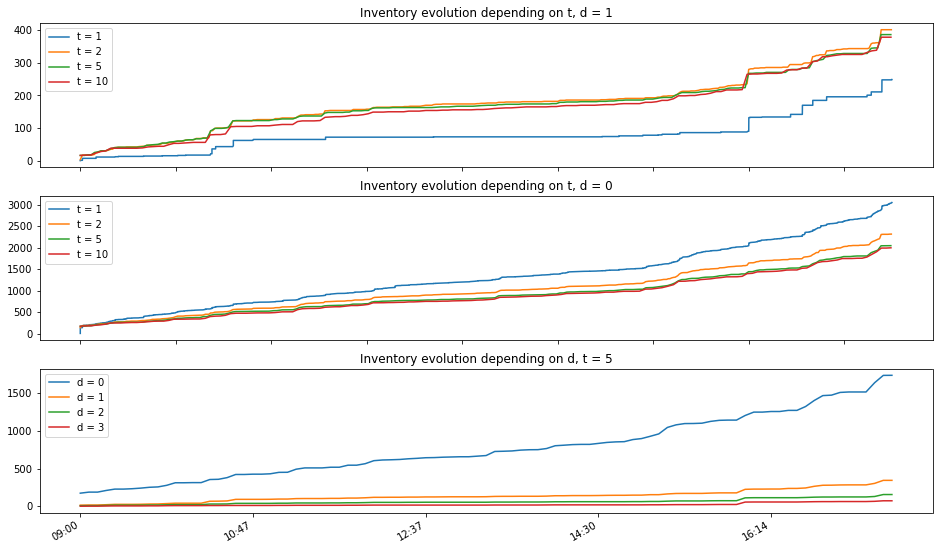

In [18]:
fig, ax = plt.subplots(3, 1, figsize=(16, 10))


for i in range(len(t_range)):
    ax[0].plot(TimeInd[i],FR_t[i].cumsum(),label = f't = {t_range[i]}')
ax[0].legend()
ax[0].set_title('Inventory evolution depending on t, d = 1')

for i,t in enumerate(t_range):
    FR,Time, midPrices = get_fill_rate_delta_time(df_trades, date_t, 0, timedelta(minutes=i), tick)
    ax[1].plot(Time,FR.cumsum(),label = f't = {t_range[i]}')
ax[1].legend()
ax[1].set_title('Inventory evolution depending on t, d = 0')


for i in range(len(t_range)):
    ax[2].plot(FR_d[i].cumsum(),label = f'd = {i}')
ax[2].legend()
ax[2].set_title('Inventory evolution depending on d, t = 5')
ax[2].xaxis.set_major_formatter(MyFormatter(TimeInd_d))

fig.autofmt_xdate()
plt.show()

Here we see that for $d=1$ different $t$ do not have a great influence on inventory when $t$ is large enough. if $t$ is too small, the invenoty would be smaller than others. This result is reasonable, because $t$ small means that we are too impatient to wait for the needed trades.

For $d = 0$, inventory decrease with $t$. This may because that price update more often when $t$ is small, so it is more probable to reach the limit order price.

It's also normal to see that the inventory increase more rapidly for small d.

### b. Study the dependence of this inventory $V$ on volatility $\sigma$ and spread $S$.

In [19]:
def get_vol_delta_time(df_trades, date_t, t):
    df_trades = df_trades.loc[date_t].droplevel(0)
    var = df_trades['TradedPrice'].resample(f'{t}Min').var().fillna(0)
    return np.array(np.sqrt(var))

In [20]:
def get_spread_delta_time(df_trades, date_t, t):
    df_trades = df_trades.loc[date_t].droplevel(0)
    S = (df_trades['AskPrice']-df_trades['BidPrice']).resample(f'{t}Min').mean()
    return S

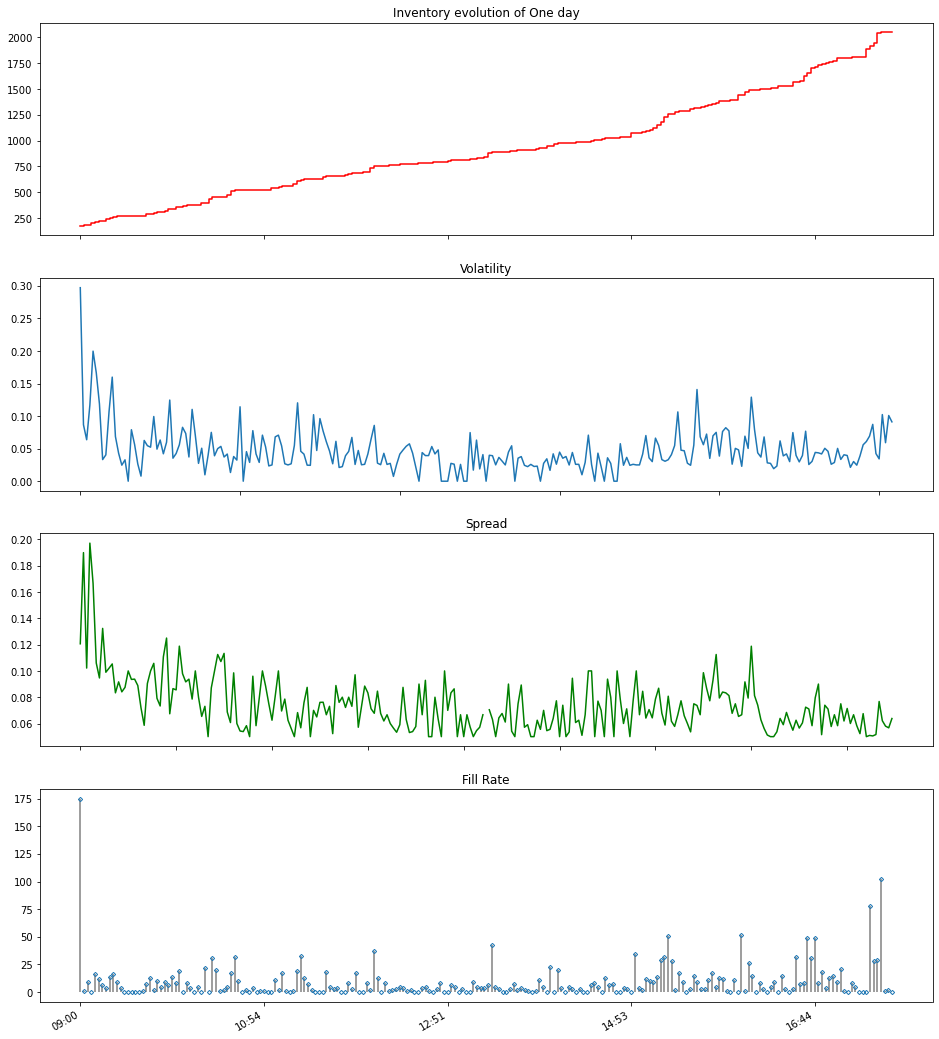

In [21]:
d = 0
t = 2
period = timedelta(minutes=t)

fillrate, time_index_fillrate, midPrices = get_fill_rate_delta_time(df_trades, date_t, d, period, tick)

fig, ax = plt.subplots(4, 1, figsize=(16, 20))
for i in range(4):
    ax[i].xaxis.set_major_formatter(MyFormatter(time_index_fillrate))
ax[1].plot(get_vol_delta_time(df_trades, date_t,t))
ax[0].step(fillrate.cumsum(),'r-')
ax[2].plot(get_spread_delta_time(df_trades, date_t,t),'g')
markerline, stemlines, baseline = ax[3].stem(fillrate, markerfmt='D', linefmt='grey', basefmt=" ")
markerline.set_markerfacecolor('none')
plt.setp(markerline, markersize = 3)
ax[0].set_title('Inventory evolution of One day')
ax[1].set_title('Volatility')
ax[2].set_title('Spread')
ax[3].set_title('Fill Rate')
fig.autofmt_xdate()
plt.show()

On observe a correlation between inventory $V$, volatility $\sigma$ and spread $S$. $V$ increase more when $\sigma$ is bigger.

### 2. Static Market Making

We consider now a market-maker using the same strategy as the agent before to buy and sell simultaneously stocks on the same market (then the distance is fixed over the day for both bid and ask sides, so it's a static strategy). We assume that at the beginning of the day the market-maker has an intial inventory $V_0 = 0$ stocks. Let $d_b$ and $d_a$ the posting distances for buying and selling respectively.

#### a. Inventory for $d_b=0$ and $n_b=15$, $d_a=0$ and $n_a=15$

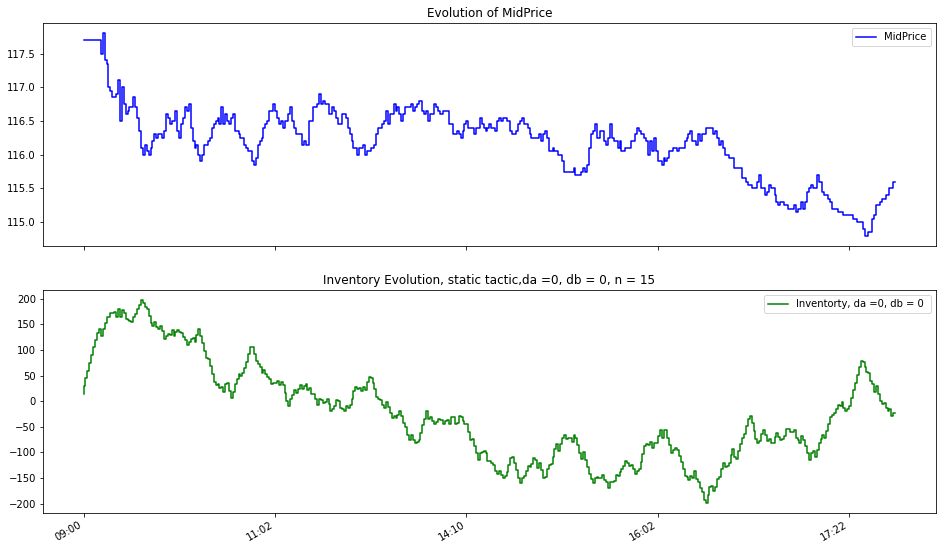

In [22]:
db, da = 0, 0 
na, nb = 15, 15

fillrate_a, time_index_fillrate, midPrices = get_fill_rate_ask(df_trades, date_t, da, na, tick)
fillrate_b, time_index_fillrate, midPrices = get_fill_rate(df_trades, date_t, db, nb, tick)
fig, ax = plt.subplots(2, 1, figsize=(16, 10))
for i in range(2):
    ax[i].xaxis.set_major_formatter(MyFormatter(time_index_fillrate))
    
ax[0].step(midPrices,'b-',label = 'MidPrice')
ax[0].legend()

ax[1].step((fillrate_b - fillrate_a).cumsum(),'g-',label = f'Inventorty, da ={da}, db = {db} ')
ax[1].legend()

ax[0].set_title('Evolution of MidPrice')
ax[1].set_title(f'Inventory Evolution, static tactic,da ={da}, db = {db}, n = 15')

plt.legend()
fig.autofmt_xdate()
plt.show()
# (fillrate_b - fillrate_a).sum()

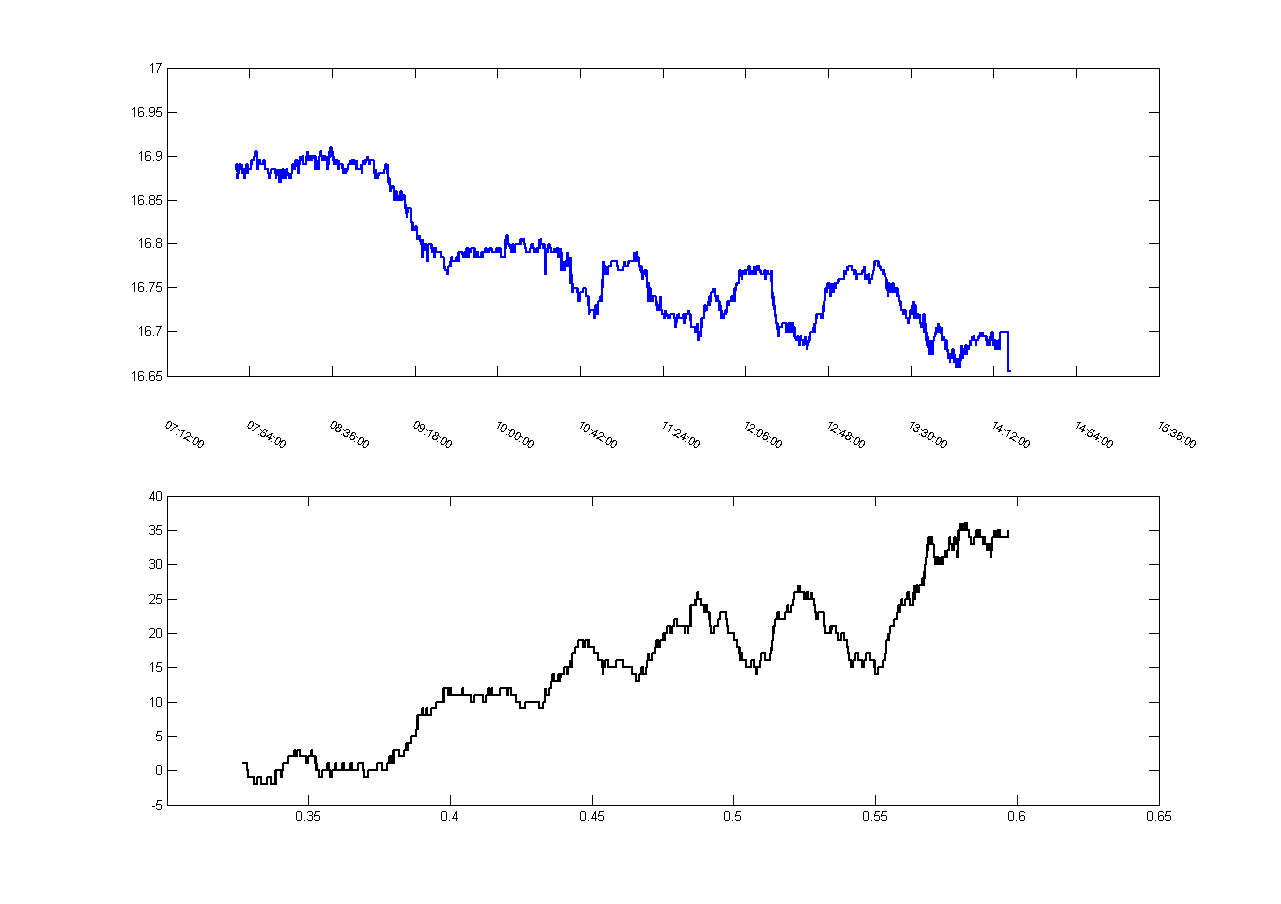

In [62]:
Image.open('imgs/MarketMaking.png')

#### b. Inventory comparison with different posting parameters

* $d_b=0$ and $n_b=15$, $d_a=0$ and $n_a=15$ (black)
* $d_b=1$ and $n_b=15$, $d_a=0$ and $n_b=15$ (gray)

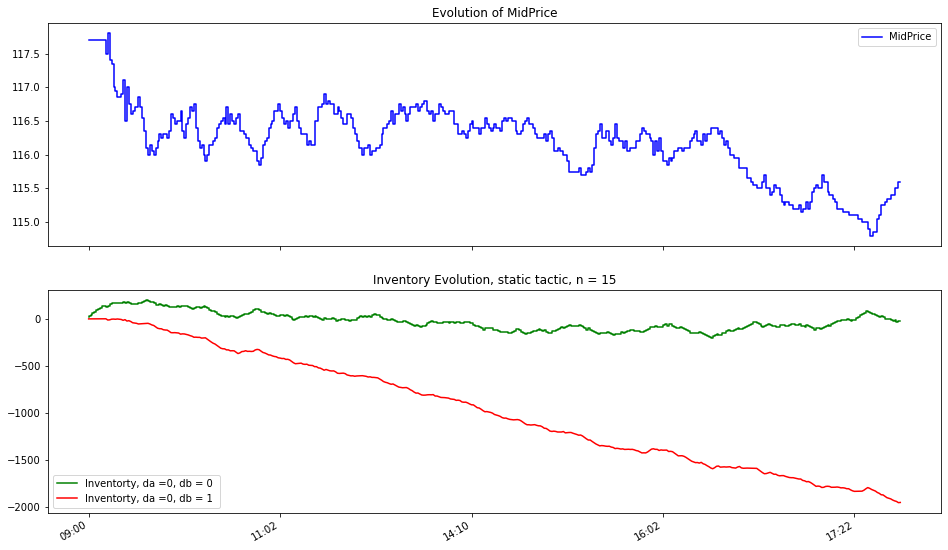

In [23]:
db, da = 0, 0 
na, nb = 15, 15
fillrate_a, time_index_fillrate, midPrices = get_fill_rate_ask(df_trades, date_t, da, na, tick)
fillrate_b, time_index_fillrate, midPrices = get_fill_rate(df_trades, date_t, db, nb, tick)
fig, ax = plt.subplots(2, 1, figsize=(16, 10))
for i in range(2):
    ax[i].xaxis.set_major_formatter(MyFormatter(time_index_fillrate))
    
ax[0].step(midPrices,'b-',label = 'MidPrice')
ax[0].legend()


ax[1].step((fillrate_b - fillrate_a).cumsum(),'g-',label = f'Inventorty, da ={da}, db = {db} ')

db, da = 1, 0 
na, nb = 15, 15
fillrate_a, time_index_fillrate, midPrices = get_fill_rate_ask(df_trades, date_t, da, na, tick)
fillrate_b, time_index_fillrate, midPrices = get_fill_rate(df_trades, date_t, db, nb, tick)

ax[1].plot((fillrate_b - fillrate_a).cumsum(),'r-',label = f'Inventorty, da ={da}, db = {db} ')

ax[1].legend()

ax[0].set_title('Evolution of MidPrice')
ax[1].set_title('Inventory Evolution, static tactic, n = 15')

plt.legend()
fig.autofmt_xdate()
plt.show()

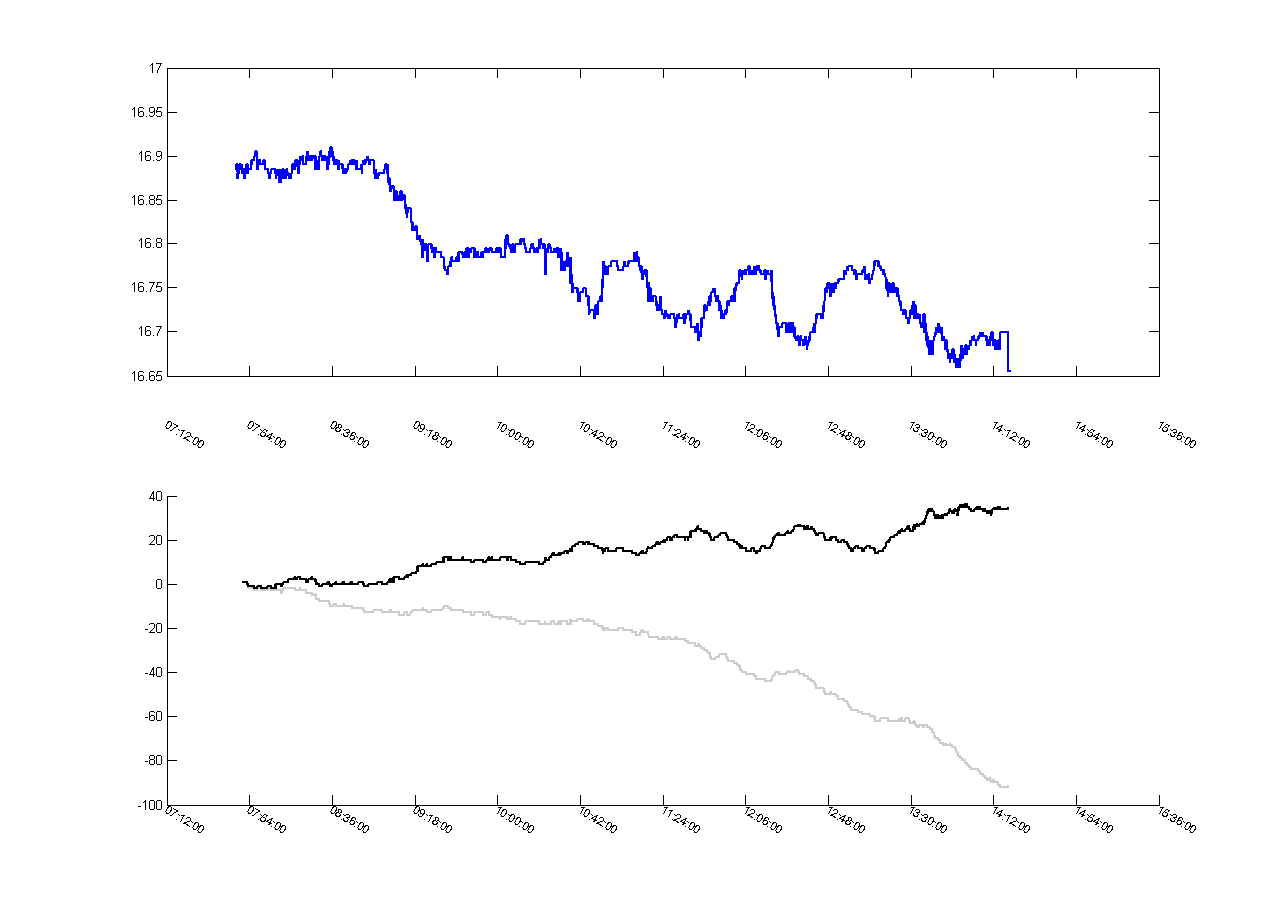

In [10]:
Image(filename='imgs/MarketMaking2.png')

**Implementation**

Let fix the duration to a few minutes.

Study the inventory evolution regarding $d_b$ and $d_a$. What are the optimal $d_b$ and $d_a$ to have a stationary inventory ?

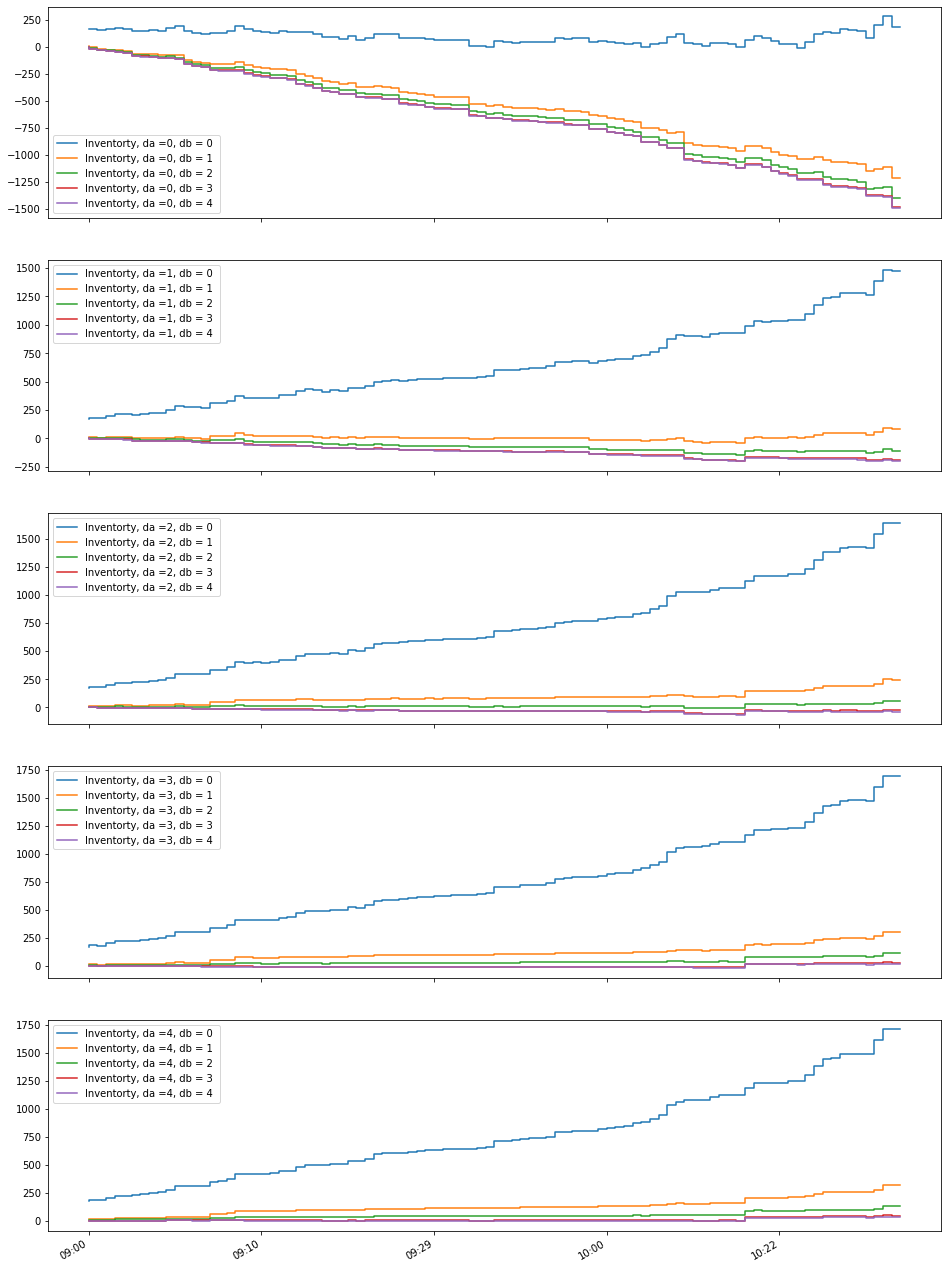

In [24]:
t = 5
period = timedelta(minutes = t)

fig, ax = plt.subplots(5, 1, figsize=(16, 25))
for i in range(5):
    ax[i].xaxis.set_major_formatter(MyFormatter(time_index_fillrate))

for da in range(5):
    for db in range(5):
        fillrate_a, time_index_fillrate, midPrices = get_fill_rate_ask_delta_time(df_trades, date_t, da, period, tick)
        fillrate_b, time_index_fillrate, midPrices = get_fill_rate_delta_time(df_trades, date_t, db, period, tick)
        ax[da].step((fillrate_b - fillrate_a).cumsum(),'-',label = f'Inventorty, da ={da}, db = {db} ')      

    ax[da].legend()

plt.legend()
fig.autofmt_xdate()
plt.show()


Here we see all the possible values of $d_a$ and $d_b$ and their corresponding inventory curves.

d_a:  1 d_b:  1 Final inventory:  80
d_a:  2 d_b:  2 Final inventory:  55
d_a:  2 d_b:  3 Final inventory:  -28
d_a:  2 d_b:  4 Final inventory:  -40
d_a:  3 d_b:  3 Final inventory:  30
d_a:  3 d_b:  4 Final inventory:  18
d_a:  4 d_b:  4 Final inventory:  32


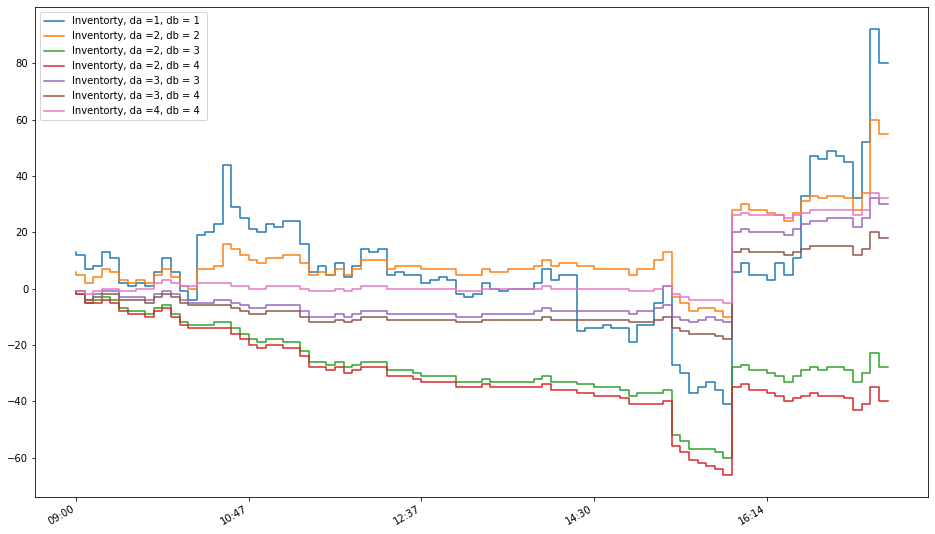

In [25]:
t = 5
period = timedelta(minutes = t)

da_range = [1,2,2,2,3,3,4]
db_range = [1,2,3,4,3,4,4]

fig, ax = plt.subplots(1, 1, figsize=(16, 10))
ax.xaxis.set_major_formatter(MyFormatter(time_index_fillrate))
for da,db in zip(da_range,db_range):
    fillrate_a, time_index_fillrate, midPrices = get_fill_rate_ask_delta_time(df_trades, date_t, da, period, tick)
    fillrate_b, time_index_fillrate, midPrices = get_fill_rate_delta_time(df_trades, date_t, db, period, tick)
    ax.step((fillrate_b - fillrate_a).cumsum(),'-',label = f'Inventorty, da ={da}, db = {db} ')
    print('d_a: ',da,'d_b: ',db,"Final inventory: ", (fillrate_b - fillrate_a).sum())
        
plt.legend()
fig.autofmt_xdate()
plt.show()

We select a few combinations of $d_a$ and $d_b$ who have a relatively stationany inventory, listed above

### 3. Dynamical Market Making

* Realtime reassessments
* Dynamical inventory
* Use market indicators to compute the posting distance

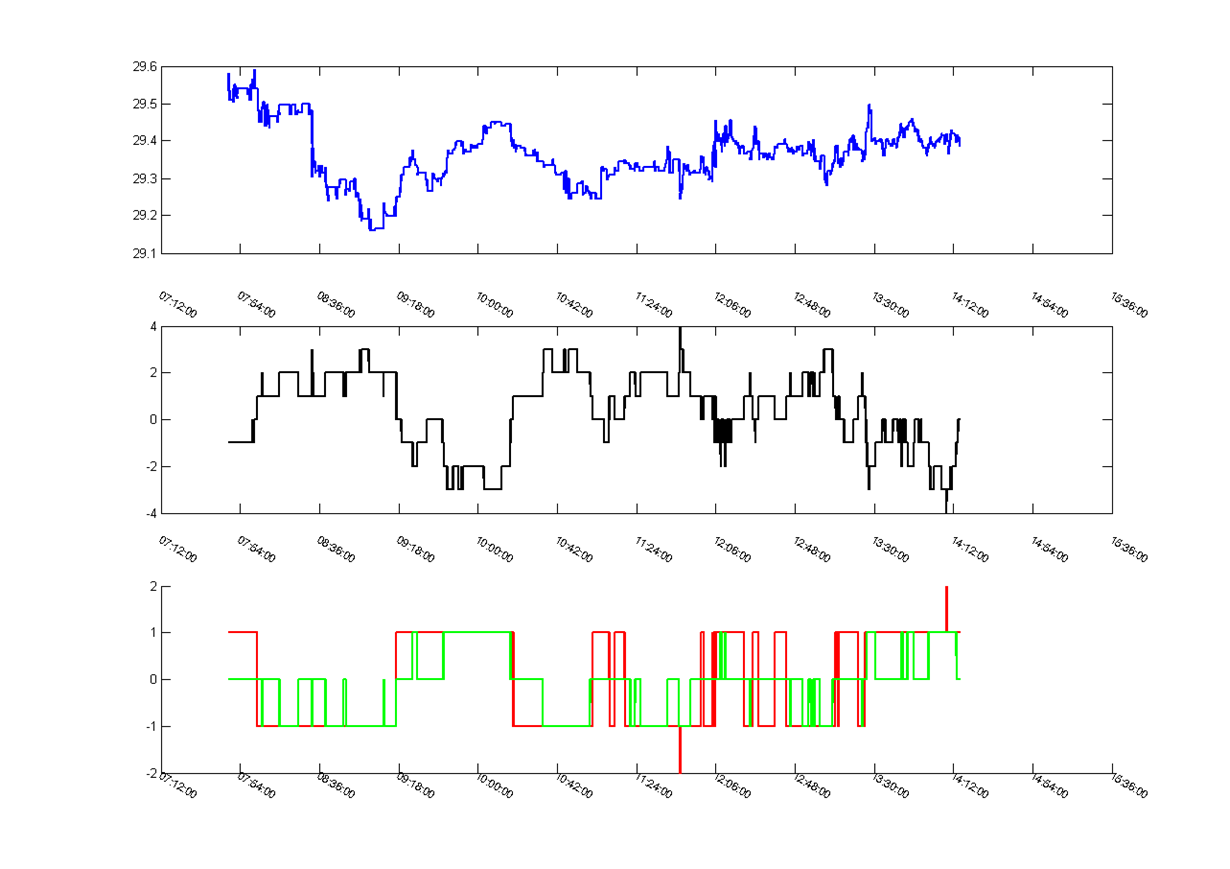

In [11]:
Image(filename='imgs/DynamicalMarketMaking.png')


**Implementation** 

Let fix the duration $t$ (a few minutes).

a. Set the posting distances $d_b$ and $d_a$ as functions of the intraday volatility : $d_{b,t} = c_b\sigma_t$ and $d_{a,t}=c_a\sigma_t$. Determine the optimal constants $c_b$ and $c_a$ to have a stationary inventory with $V_0=0$. 

b. Plot on the same graph the evolutions of inventory, price and volatility for the optimal values of $c_b$ and $c_a$. Comment.

c. What is the dependency of the optimal strategy regarding the initial inventory $V_0$ (positive or negative) ?

d. Propose other intraday parameters which could be used to optimize the posting price. Justify your choice. 


### a. Determine the optimal constants $c_b$ and $c_a$ to have a stationary inventory with $V_0=0$. 


In [45]:
def get_PnL_FR_bid_dynam(df_trades, date_t, cb, period, tick):
    """
    period is a timedelta
    """
    time_index = df_trades.loc[date_t].droplevel(0).index
    best_bid_prices = df_trades.loc[date_t, "BidPrice"].to_numpy(copy=True)
    best_ask_prices = df_trades.loc[date_t, "AskPrice"].to_numpy(copy=True)
    traded_prices = df_trades.loc[date_t, "TradedPrice"].to_numpy(copy=True)
    M = best_bid_prices.shape[0]
    fillrate, time_index_fillrate, midPrices, d_suites = [], [], [],[]
    i = 0
    PnL = []
    vol_suites = []
    while i < M:
        time_index_fillrate.append(time_index[i])
        midPrices.append((best_ask_prices[i] + best_ask_prices[i]) / 2)
        end_time = time_index[i] + period
        
        end_i = (time_index > end_time).argmax()
        if end_i <=0:
            end_i = M
        vol = np.sqrt(traded_prices[i:end_i].var())
        vol_suites.append(vol)
        cnt = 0
        d = int(cb * vol)
        if d > 4:
            d = 4
        
        d_suites.append(d)
        last_price = best_bid_prices[i] - d*tick
        price = 0
        
        while i < M and time_index[i] <= end_time:
            if traded_prices[i] <= last_price:
                cnt += 1
                price += traded_prices[i]
                last_price = best_bid_prices[i] - d*tick
            i += 1
        fillrate.append(cnt)
        PnL.append(price)
    fillrate = np.array(fillrate)
    return fillrate, time_index_fillrate, midPrices,d_suites,np.array(PnL),np.array(vol_suites)

In [46]:
def get_PnL_FR_ask_dynam(df_trades, date_t, ca, period, tick):
    """
    period is a timedelta
    """
    time_index = df_trades.loc[date_t].droplevel(0).index
    best_bid_prices = df_trades.loc[date_t, "BidPrice"].to_numpy(copy=True)
    best_ask_prices = df_trades.loc[date_t, "AskPrice"].to_numpy(copy=True)
    traded_prices = df_trades.loc[date_t, "TradedPrice"].to_numpy(copy=True)
    M = best_bid_prices.shape[0]
    fillrate, time_index_fillrate, midPrices, d_suites = [], [], [],[]
    i = 0
    PnL = []
    vol_suites = []
    
    while i < M:
        time_index_fillrate.append(time_index[i])
        midPrices.append((best_ask_prices[i] + best_ask_prices[i]) / 2)
        end_time = time_index[i] + period
        
        end_i = (time_index > end_time).argmax()
        if end_i <=0:
            end_i = M
        vol = np.sqrt(traded_prices[i:end_i].var())
        vol_suites.append(vol)
        cnt = 0
        d = int(ca * vol)
        if d > 4:
            d = 4
        
        d_suites.append(d)
        last_price = best_ask_prices[i] + d*tick
        
        price = 0
        while i < M and time_index[i] <= end_time:
            if traded_prices[i] >= last_price:
                cnt += 1
                price += traded_prices[i]
                last_price = best_ask_prices[i] + d*tick
            i += 1
        fillrate.append(cnt)
        PnL.append(price)
    fillrate = np.array(fillrate)
    return fillrate, time_index_fillrate, midPrices,d_suites,np.array(PnL),np.array(vol_suites)

c_a:  3 c_a:  5 Final Inventory:  9
c_a:  4 c_a:  5 Final Inventory:  4
c_a:  8 c_a:  7 Final Inventory:  -6
c_a:  10 c_a:  10 Final Inventory:  -8
c_a:  14 c_a:  15 Final Inventory:  3
c_a:  16 c_a:  16 Final Inventory:  4
c_a:  17 c_a:  17 Final Inventory:  6


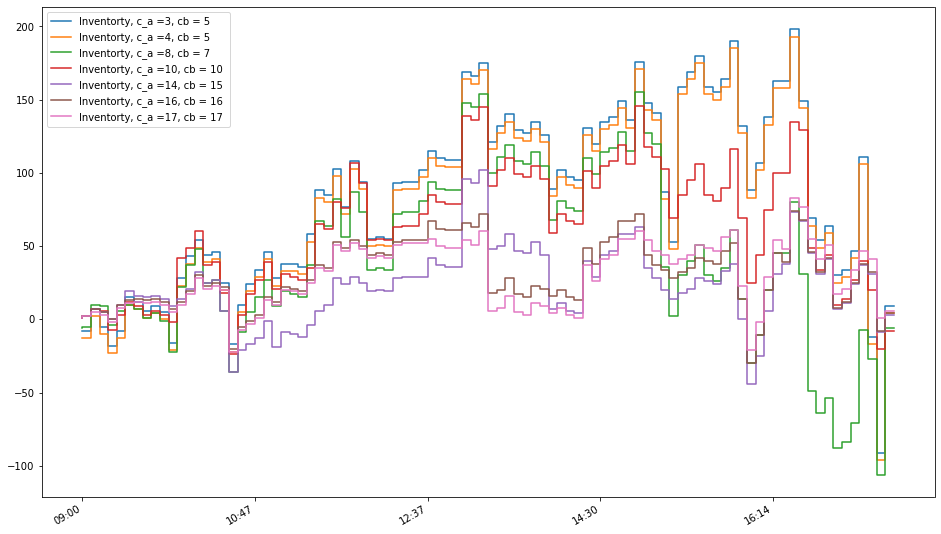

In [47]:
t = 5
period = timedelta(minutes = t)
# ans = 10e10
ca_range = [3,4,8,10,14,16,17]
cb_range = [5,5,7,10,15,16,17]

fig, ax = plt.subplots(1, 1, figsize=(16, 10))
ax.xaxis.set_major_formatter(MyFormatter(time_index_fillrate))
for ca,cb in zip(ca_range,cb_range):
    fillrate_a, time_index_fillrate, midPrices,d_suites,_,_ = get_PnL_FR_ask_dynam(df_trades, date_t, ca, period, tick)
    fillrate_b, time_index_fillrate, midPrices,d_suites,_,_ = get_PnL_FR_bid_dynam(df_trades, date_t, cb, period, tick)
    #         print(fillrate_a.sum(), fillrate_b.sum())
    print('c_a: ',ca,'c_a: ',cb,'Final Inventory: ',(fillrate_a-fillrate_b).sum())
    ax.step( (fillrate_a-fillrate_b).cumsum(),'-', label = f'Inventorty, c_a ={ca}, cb = {cb} ')
#     ans = min(ans,abs((fillrate_a-fillrate_b).sum()))
    
ax.legend()

plt.legend()
fig.autofmt_xdate()
plt.show()

For dynamic strategies, we could have a final inventory much closer to 0. The inventory curves are both stationary for dynamic and static strategies. The possible values of $c_a$ and $c_b$ are listed above.

### b. Plot on the same graph the evolutions of inventory, price and volatility for the optimal values of $c_b$ and $c_a$. Comment.


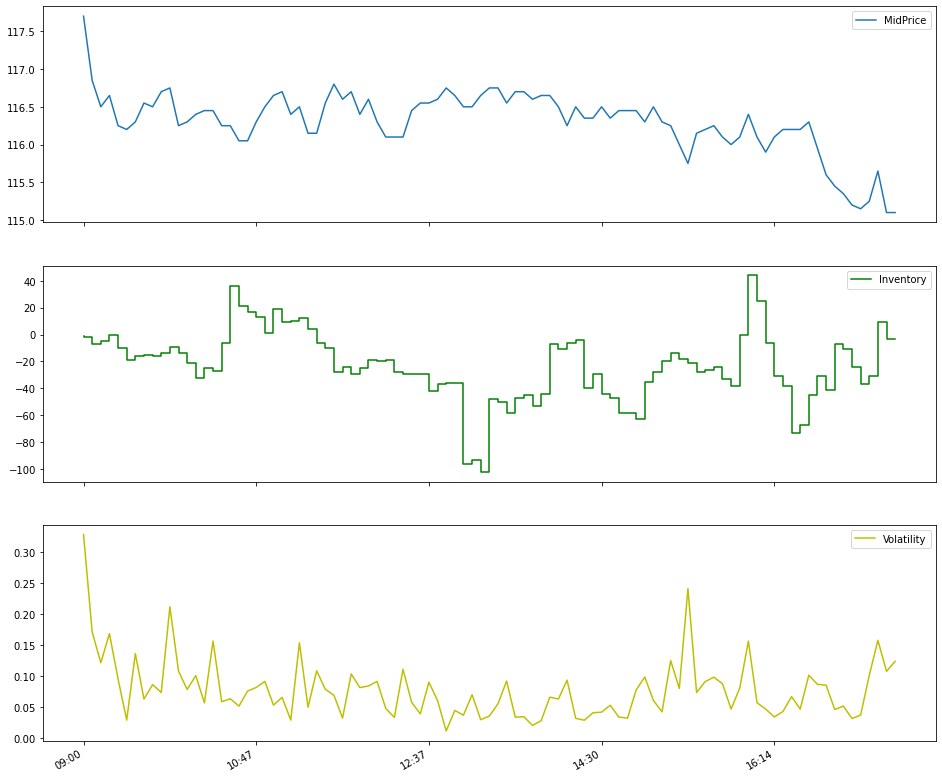

In [57]:
ca,cb = 14,15
t = 5
period = timedelta(minutes = t)

# da_range = [1,2,2,2,3,3,4]
# db_range = [1,2,3,4,3,4,4]

fig, ax = plt.subplots(3, 1, figsize=(16, 15))
for i in range(3):
    ax[i].xaxis.set_major_formatter(MyFormatter(time_index_fillrate))
ax[0].plot(midPrices, label = 'MidPrice')
ax[0].legend()
fillrate_a, time_index_fillrate, midPrices,d_suites,_,vol_a = get_PnL_FR_ask_dynam(df_trades, date_t, ca, period, tick)
fillrate_b, time_index_fillrate, midPrices,d_suites,_,vol_b = get_PnL_FR_bid_dynam(df_trades, date_t, cb, period, tick)

ax[1].step((fillrate_b-fillrate_a).cumsum(),'g-', label = 'Inventory')
ax[1].legend()
ax[2].plot(vol_a,'y',label = "Volatility")
    
plt.legend()
fig.autofmt_xdate()
plt.show()

Inventory fluctuates more significantly when MidPrice has a obvious trend. Inventory does not necessarily change much when volatility is big.

### c. What is the dependency of the optimal strategy regarding the initial inventory $V_0$ (positive or negative) ?



When $V_0$ is not 0, say positive, we would be allowed to sell more stocks. In this way, the strategy with a negative inventory at the end of the day will be more preferable for us 

### d. Propose other intraday parameters which could be used to optimize the posting price. Justify your choice. 


We could use the number of trades as the parameter to optimize the posting price, because when there are many trades, obviously, it is more probable for the price far from the best price to be executed.

## 4. P&L

**Implementation**

For the same market maker, we consider that the remaining stocks at the end of the day have to be traded at the close (the last price of the day) to get a zero final inventory. 

a. Plot and compare the P&L of the optimal strategies obtained in the previous section (for fixed $d_b$ and $d_a$ and as functions of intraday volatility). Add on the graphs the price, the inventory and the volatility. 

b. Do you think that it is always possible to liquidate an inventory at the closing price ?

c. Study the dependence of the P&L to the inventory. If the posting distance depends on both inventory and volatility $d_t=f(V_t,\sigma_t)$, what could be the shape of $f$ to optimize the closing P&L ?

### a. Plot and compare the P&L of the optimal strategies obtained in the previous section


In [33]:
def get_PnL_FR_delta_time_bid(df_trades, date_t, d, period, tick):
    """
    period is a timedelta
    """
    df_trades = df_trades.loc[date_t].droplevel(0)
    best_bid_prices = df_trades.loc[date_t, "BidPrice"].to_numpy(copy=True)
    best_ask_prices = df_trades.loc[date_t, "AskPrice"].to_numpy(copy=True)
    traded_prices = df_trades.loc[date_t, "TradedPrice"].to_numpy(copy=True)
    M = best_bid_prices.shape[0]
    fillrate, time_index_fillrate, midPrices = [], [], []
    i = 0
    PnL = []
    
    while i < M:
        cnt = 0
        last_price = best_bid_prices[i] - d*tick
        end_time = df_trades.index[i] + period
        time_index_fillrate.append(df_trades.index[i])
        midPrices.append((best_ask_prices[i] + best_ask_prices[i]) / 2)
        price = 0
        while i < M and df_trades.index[i] <= end_time:
            if traded_prices[i] <= last_price:
                cnt += 1
                price += traded_prices[i]
                last_price = best_bid_prices[i] - d*tick
            i += 1
        fillrate.append(cnt)
        PnL.append(price)
    fillrate = np.array(fillrate)
    return fillrate, time_index_fillrate, midPrices,np.array(PnL)

In [34]:
def get_PnL_FR_delta_time_ask(df_trades, date_t, d, period, tick):
    """
    period is a timedelta
    """
    time_index = df_trades.loc[date_t].droplevel(0).index
    best_bid_prices = df_trades.loc[date_t, "BidPrice"].to_numpy(copy=True)
    best_ask_prices = df_trades.loc[date_t, "AskPrice"].to_numpy(copy=True)
    traded_prices = df_trades.loc[date_t, "TradedPrice"].to_numpy(copy=True)
    M = best_bid_prices.shape[0]
    fillrate, time_index_fillrate, midPrices = [], [], []
    i = 0
    PnL = []
    while i < M:
        cnt = 0
        last_price = best_ask_prices[i] + d*tick
        time_index_fillrate.append(time_index[i])
        midPrices.append((best_ask_prices[i] + best_ask_prices[i]) / 2)
        end_time = time_index[i] + period
        price = 0
        while i < M and time_index[i] <= end_time:
            if traded_prices[i] >= last_price:
                cnt += 1
                price += traded_prices[i]
                last_price = best_ask_prices[i] + d*tick
            i += 1
        fillrate.append(cnt)
        PnL.append(price)
    fillrate = np.array(fillrate)
    return fillrate, time_index_fillrate, midPrices,np.array(PnL)

In [35]:
best_bid_prices = df_trades.loc[date_t, "BidPrice"].to_numpy(copy=True)
best_ask_prices = df_trades.loc[date_t, "AskPrice"].to_numpy(copy=True)

#### For static strategies

In [37]:
# da,db = 3,4
t = 5
period = timedelta(minutes = t)

da_range = [1,2,2,2,3,3,4]
db_range = [1,2,3,4,3,4,4]

# fig, ax = plt.subplots(1, 1, figsize=(16, 10))
# ax.xaxis.set_major_formatter(MyFormatter(time_index_fillrate))

for da,db in zip(da_range,db_range):
    fillrate_a, time_index_fillrate_a, midPrices,PnL_b = get_PnL_FR_delta_time_bid(df_trades, date_t, da, period, tick)
    fillrate_b, time_index_fillrate_b, midPrices,PnL_a = get_PnL_FR_delta_time_ask(df_trades, date_t, db, period, tick)

    PnL = (PnL_a - PnL_b).cumsum()
    rest = (fillrate_b - fillrate_a).sum()
    if rest > 0:
        PnL[-1] += -rest * best_bid_prices[-1]
    else:
        PnL[-1] += -rest * best_ask_prices[-1]
    print('d_a:', da,'        d_b:',db,'             Final PnL:', PnL[-1])
#     ax.step(PnL,'-',label = f'PnL, da ={da}, db = {db} ')
#         print(da,db,(fillrate_b - fillrate_a).sum())
        
# plt.legend()
# fig.autofmt_xdate()
# plt.show()



d_a: 1         d_b: 1              Final PnL: 80.59999999999854
d_a: 2         d_b: 2              Final PnL: 36.099999999999454
d_a: 2         d_b: 3              Final PnL: -0.8499999999985448
d_a: 2         d_b: 4              Final PnL: -12.850000000000364
d_a: 3         d_b: 3              Final PnL: 20.999999999997726
d_a: 3         d_b: 4              Final PnL: 9.0
d_a: 4         d_b: 4              Final PnL: 11.899999999998727


Here we have the PnL of different $d_a$ and $d_b$ previously selected on section $3$. 

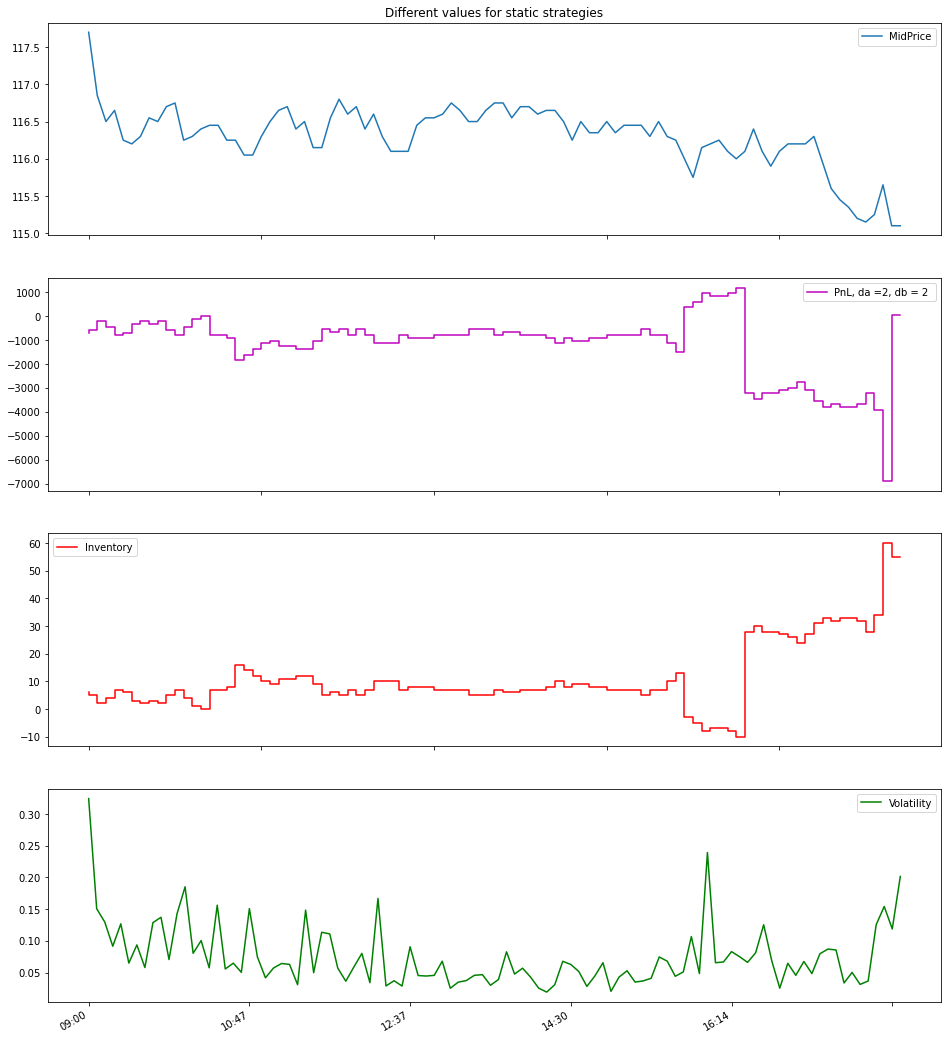

In [52]:
da,db = 2,2
t = 5
period = timedelta(minutes = t)

da_range = [1,2,2,2,3,3,4]
db_range = [1,2,3,4,3,4,4]

fig, ax = plt.subplots(4, 1, figsize=(16, 20))
for i in range(4):
    ax[i].xaxis.set_major_formatter(MyFormatter(time_index_fillrate))
ax[0].plot(midPrices, label = 'MidPrice')
ax[0].legend()
fillrate_a, time_index_fillrate_a, midPrices,PnL_b = get_PnL_FR_delta_time_bid(df_trades, date_t, da, period, tick)
fillrate_b, time_index_fillrate_b, midPrices,PnL_a = get_PnL_FR_delta_time_ask(df_trades, date_t, db, period, tick)

PnL = (PnL_a - PnL_b).cumsum()
rest = (fillrate_b - fillrate_a).sum()
if rest > 0:
    PnL[-1] += -rest * best_bid_prices[-1]
else:
    PnL[-1] += -rest * best_ask_prices[-1]
# print(da,db,PnL[-1])
ax[1].step(PnL,'m-',label = f'PnL, da ={da}, db = {db} ')
ax[1].legend()
#         print(da,db,(fillrate_b - fillrate_a).sum())

ax[2].step((fillrate_a-fillrate_b).cumsum(),'r-', label = 'Inventory')
ax[2].legend()
ax[3].plot(get_vol_delta_time(df_trades, date_t, t),'g',label = "Volatility")

ax[0].set_title('Different values for static strategies')
plt.legend()
fig.autofmt_xdate()
plt.show()


PnL has almost the same form with Inventory. PnL fluctuates more significantly when MidPrice has a obvious trend. PnLdoes not necessarily change much when volatility is big.

#### For dynamic strategies

In [54]:
t = 5
period = timedelta(minutes = t)
ans = 10e10
ca_range = [3,4,8,10,14,16,17]
cb_range = [5,5,7,10,15,16,17]

# fig, ax = plt.subplots(1, 1, figsize=(16, 10))

for ca,cb in zip(ca_range,cb_range):
    fillrate_a, time_index_fillrate, midPrices,d_suites,PnL_a,_ = get_PnL_FR_ask_dynam(df_trades, date_t, ca, period, tick)
    fillrate_b, time_index_fillrate, midPrices,d_suites,PnL_b,_ = get_PnL_FR_bid_dynam(df_trades, date_t, cb, period, tick)
    #         print(fillrate_a.sum(), fillrate_b.sum())
#     print(ca,cb,(fillrate_a-fillrate_b).sum())
    PnL = (PnL_a - PnL_b).cumsum()
#     print(PnL)
    rest = (fillrate_b - fillrate_a).sum()
    if rest > 0:
        PnL[-1] += -rest * best_bid_prices[-1]
    else:
        PnL[-1] += -rest * best_ask_prices[-1]
    print('c_a:', ca,'     c_a:',cb,'     PnL:',PnL[-1],(fillrate_a-fillrate_b).sum())

# ax.legend()

# plt.legend()
# fig.autofmt_xdate()
# plt.show()

c_a: 3      c_a: 5      PnL: 2487.200000000023 9
c_a: 4      c_a: 5      PnL: 1319.700000000023 4
c_a: 8      c_a: 7      PnL: -1094.899999999985 -6
c_a: 10      c_a: 10      PnL: -1519.3500000000138 -8
c_a: 14      c_a: 15      PnL: 908.249999999985 3
c_a: 16      c_a: 16      PnL: 1114.599999999987 4
c_a: 17      c_a: 17      PnL: 1580.3999999999887 6


The above are PnL of different $c_a$ and $c_b$ previously selected on section $3$. we see that PnL are much greater than that in the static strategies. This shows the effectiveness of the dynamic strategy.

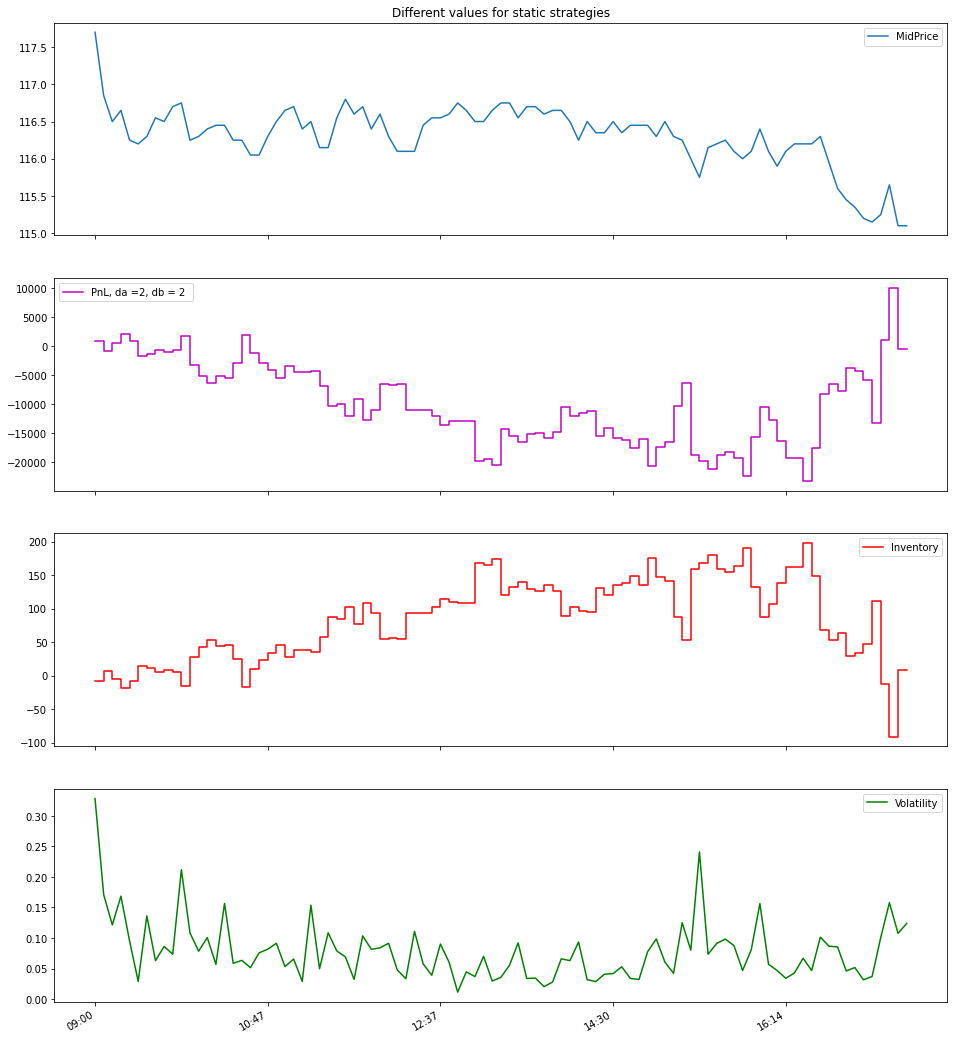

In [58]:
ca,cb = 3,5
t = 5
period = timedelta(minutes = t)

fig, ax = plt.subplots(4, 1, figsize=(16, 20))
for i in range(4):
    ax[i].xaxis.set_major_formatter(MyFormatter(time_index_fillrate))
ax[0].plot(midPrices, label = 'MidPrice')
ax[0].legend()
fillrate_a, time_index_fillrate_a, midPrices,_,PnL_b,vol_a = get_PnL_FR_ask_dynam(df_trades, date_t, ca, period, tick)
fillrate_b, time_index_fillrate_b, midPrices,_,PnL_a,vol_b = get_PnL_FR_bid_dynam(df_trades, date_t, cb, period, tick)

PnL = (PnL_a - PnL_b).cumsum()
rest = (fillrate_b - fillrate_a).sum()
if rest > 0:
    PnL[-1] += -rest * best_bid_prices[-1]
else:
    PnL[-1] += -rest * best_ask_prices[-1]
# print(da,db,PnL[-1])
ax[1].step(PnL,'m-',label = f'PnL, da ={da}, db = {db} ')
ax[1].legend()
#         print(da,db,(fillrate_b - fillrate_a).sum())

ax[2].step((fillrate_a-fillrate_b).cumsum(),'r-', label = 'Inventory')
ax[2].legend()
ax[3].plot(vol_a,'g',label = "Volatility")

ax[0].set_title('Different values for static strategies')
plt.legend()
fig.autofmt_xdate()
plt.show()

PnL has almost the same form with Inventory. PnL fluctuates more significantly when MidPrice has a obvious trend. PnL also has a strong correlation with volatility.

### b. Do you think that it is always possible to liquidate an inventory at the closing price ?



No, it is very possible to not be able to liquidate an inventory, expecially when an inventory is large. There may not have enough limit orders on the market, or it may cost too much to liquidate.

### c. Study the dependence of the P&L to the inventory. If the posting distance depends on both inventory and volatility $d_t=f(V_t,\sigma_t)$, what could be the shape of $f$ to optimize the closing P&L ?

Intuitively, I would like to say that:
$$ d_t = c \frac{\sigma_t}{V_t}$$
This shape of $f$ can help to optimize the closing P&L. $d$ increase with $\sigma$ as in section $3$ (the implemented dynamic strategy). $d$ decrease with $V$ because we tend to trade more, which demande $d$ small, when $V$ is too large.